# <span style="color:green"> Environmental Sound Classification </span>
## <span style="color:green">Notebook 2: Feature Classification </span>

---
[Mattia Pujatti](mattia.pujatti.1@studenti.unipd.it), ID 1232236, master degree in Physics of Data

---

This notebook has been realized as final project for the course of Human Data Analytics, held by professors [Michele Rossi](rossi@dei.unipd.it) and [Francesca Meneghello](meneghello@dei.unipd.it), during the academic year 2019/2020 at the University of Padua.

### Table of Content

1. #### [Introduction](#Introduction) 
2. #### [Dataset](#The-Dataset)
3. #### [Audio Features](#Audio-Features)
    *
    *
4. #### [Dataset Construction](#Dataset-Construction)
5. #### [Correlation Matrix](#Correlation-Matrix)

## Project Presentation

*The main purpose of this notebook will be to provide an efficient way, using machine learning techniques, to classify environmental sound clips belonging to one of the only public available dataset on the internet. <br>
Several approaches have been tested during the years, but only a few of them were able to reproduce or even overcome the human classification accuracy, that was estimated around 81.30%. <br>
The analysis will be organized in the following way: since the very first approaches were maily focused on the examination of audio features that one could extract from raw audio files, we will provide a way to collect and organize all those "vector of features" and use them to distinguish among different classes. Then, different classification architectures and techniques will be implemented and compared among each other, in order also to show how they react to different data manipulation (overfitting, numerical stability,...). <br>
In the end, it will be shown that all those feature classifiers, without exceptions, underperform when compared to the results provided by the use of Convolutional Neural Networks directly on audio signals and relative spectrograms (so without any kind of feature extraction), and how this new approach opened for a large number of opportunities in term of models with high accuracy in sound classification.*

### Summary of Notebook 1

In the first [notebook](

## Introduction to Notebook 2

*Spiegazione*

---

As our main instrument for constructing and training Machine Learning models, with the purpose of classifying environmental sounds, will be __keras__, an highlevel api of the platform __tensorflow__. <br>
Just a quick technical remark: we will import all keras functions and objects via _tf.keras_, and not just via _keras_, because of some incompatibility between the two modules.

In [92]:
# Requirements
import os
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

In [35]:
from tqdm.keras import TqdmCallback
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

## Dataset Comparison

In the previous notebook we have created several _csv_ file containing all the vectors of features extracted from the audio files in the original dataset. We have already recalled, in the introduction, that for each clip we derived complessively 55 different features per frame, and in order to summarize those features we decide to take the mean and/or the standard deviation of the corresponding distributions. We also removed some silent parts in the calculation to have more "uniform" and consistent results, and, in the end, we augmented the data in order to have more available sounds. <br>
So we ended up with the following files:
* `features.csv`: uses mean and standard deviation to represent the features distributions and was corrected via silence removal with a window of 0.5 seconds.
* `features_nosilenceremoval.csv`: also this file uses both mean and std to represent features distribution but, as the name suggests, no silence removal was applied, mainly to show the effective improvement that this procedure guarantees.
* `reduced_features.csv`: differently from the first two, in this file only the mean of the features is reported; silence removal was instead correctly applied.
* `augmented_features.csv`: this file has been generated from the augmented data constructed applying to every clip in the original dataset 4 different augmentation procedures, resulting in a collection of clips five times bigger.

The following table summarize all the available data for classification.

| Filename | Features Length | Number of Clips | Silence Removal | Augmented |
| :--- | :--- | :--- | :--- | :--- |
| features.csv | 110 | 2000 | Yes | No |
| features_nosilenceremoval.csv | 110 | 2000 | No | No |
| reduced_features.csv | 55 | 2000 | Yes | No |
| augmented_features.csv | 110 | 10000 | Yes | Yes |

In [3]:
# Let's load the datasets
features = pd.read_csv("features.csv", index_col=0)
features_nosilenceremoval = pd.read_csv("features_nosilenceremoval.csv", index_col=0)
reduced_features = pd.read_csv("reduced_features.csv", index_col=0)
augmented_features = pd.read_csv("augmented_features.csv", index_col=0)
augmented_features

,0,1,2,3,4,5,6,7,8,9,...,101,102,103,104,105,106,107,108,109,label
0,10849.601157,918.057984,18598.941982,945.065637,6370.751663,123.212212,0.485326,0.066063,0.046367,0.034819,...,0.510865,0.462348,0.497908,0.530278,0.440784,0.504250,0.503728,0.486035,0.488766,dog
1,9990.634558,559.101005,18132.805589,516.790446,6439.145801,148.285112,0.391947,0.068640,0.072870,0.031348,...,0.613910,0.542764,0.569944,0.649563,0.671917,0.506207,0.693061,0.575784,0.549581,chirping_birds
2,4779.126541,328.861758,9031.055367,488.682171,4592.885754,144.489410,0.200383,0.028605,0.271595,0.046680,...,0.551372,0.492177,0.536389,0.522492,0.562115,0.558984,0.570263,0.589155,0.527654,vacuum_cleaner
3,4480.194905,229.432479,8562.670729,323.455861,4134.897304,115.367570,0.202144,0.021189,0.275287,0.066021,...,0.574609,0.515944,0.493575,0.476780,0.479676,0.449910,0.554374,0.568633,0.512262,vacuum_cleaner
4,10159.868973,672.106116,18427.875421,329.407384,6725.294146,206.106674,0.390444,0.086304,0.015039,0.004850,...,0.475644,0.571642,0.568560,0.469428,0.505913,0.501398,0.493625,0.519823,0.513859,thunderstorm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1918.757528,303.783879,3106.227002,644.665288,2170.010452,434.008532,0.053308,0.018209,0.085123,0.087223,...,1.589473,0.908361,1.263996,0.991909,0.835533,0.968926,0.802479,0.763298,0.794067,hen
9996,5685.663242,143.534391,11292.940994,253.468461,4396.309142,68.666402,0.227157,0.017203,0.119567,0.003821,...,0.536032,0.487366,0.492283,0.451245,0.463138,0.476303,0.451795,0.511070,0.498505,vacuum_cleaner
9997,1931.486868,1329.795683,4316.632831,3188.653985,2824.456677,1655.568125,0.025522,0.025662,0.065660,0.094834,...,1.224146,0.850813,0.775175,0.799110,0.885374,0.834324,0.756124,0.759324,0.636704,footsteps
9998,3503.472061,940.171052,7393.582670,3105.111474,3994.320503,921.695082,0.075558,0.021528,0.061051,0.040678,...,0.767034,0.722414,0.723565,0.600105,0.629163,0.528401,0.590463,0.632595,0.592112,sheep


## Clips Classifier

Following the same technique used also in the first notebook we will define a class to handle all the necessary steps to construct and train a machine learning model over our datasets. <br>
The class is supposed to work with a dataset formatted like the ones shown before, in which each line correspond to a vector of features while the last column contains the categorical label of the clip. More in practice, such data should be renormalized and their labels should be encoded in a format that is congenial to the machine learning classifiers. <br>
Moreover, the class is supposed to provide several functions to automatize the training process, the hyperparameter tuning and the final validation of the model. But there is a problem with 3 out of 4 of our datasets: they are composed just by 2000 clips, which is never enough to train properly a 50-classes classifier! We can't even talk about splitting the clips in a train-validation-test sets, because we won't have enough data to construct a significative statistics, and so we will rely on a technique (suggested also inside the same library _sklearn_) called __nested cross-validation__. A non-nested approach consists in using the same cross-validation procedure and data both to tune and select a model, but this is likely to lead to an optimistically biased evaluation of the model performance (because of  information leakage). Nested Cross-Validation (Nested-CV) nests cross-validation and hyperparameter tuning exploiting two different KFold (or stratified KFold) splitting, such that in the inner loop the score is approximately maximized by fitting a model to each training set, and then directly maximized in selecting (hyper)parameters over the validation set; in the outer loop, instead, the generalization error is estimated by averaging test set scores over several dataset splits. <br>
Under this procedure, hyperparameter search does not have an opportunity to overfit the dataset as it is only exposed to a subset of the dataset provided by the outer cross-validation procedure. This reduces, if not eliminates, the risk of the search procedure overfitting the original dataset and should provide a less biased estimate of a tuned model’s performance on the dataset. Obviously, this does not come without any additional cost, since you dramatically increase the number of intermediate steps: if _n*k_ models are fit and evaluated as part of a traditional non-nested CV for a given model, then this number is increased to _k*n*k_ as the procedure is then performed _k_ more times for each fold in the outer loop of nested CV.

This is the internal structure of the class `ClipsClassifier`:

* `__init__`: the constructor of the class that takes in input a pandas dataframe, splitting features and labels;
* `Setup_Classifier`: function used to modify the default values chosen for some parameters/methods implemented by the class, like:

    * the number of components to keep after the Principal Component Analysis (default = all);
    * the number of folds to use in the cross validation (defualt = 5);
    * the verbosity of the messages printed;
    * the encoder method for the labels (LabelEncoder or OneHotEncoder, default = onehot).
    
* `_Create_Pipeline`: in order to simplify the features setup and training procedure we rely on a sklearn Pipeline containing a standardization function (StandardScaler), a dimensionality reduction step (PCA) and the model that we want to fit;
* `Run_Nested_Cross_Validation`: this function implement all the steps necessary to run a nested cross validation for our model over the initial dataset, fitting the pipeline and performing a GridSearch over the dictionary of hyperparameters provided; additionally, it will compute the effective performances via _cross-val-predict_ over the different folds and, if requested, compute also the confusion matrix;
* `Run_Nested_Cross_Validation`: like _Run_Nested_Cross_Validation_, but with an initial split of the data into a training and a test set.

In [44]:
class ClipsClassifier():
    """The purpose of this class is to collect all the necessary steps and functions to construct a classification
    model for our clips. 
    In particular, all the necessary steps to prepare the input dataset for the training process will 
    be implemented:
    * standardization
    * PCA
    * Label Encoding
    * train test split or K-fold splitting
    Then a grid search can be run in order to test several combination of hyperparameters without constructing 
    directly a validation set. In the end, the performances will be shown in term of accuracy also over the
    different macro-categories to finally quantify the quality of the model constructed.
    """
    
    def __init__(self, dataset):
        """Initialize some global parameters.
        Dataset is a pandas dataframe with several "features" columns and one "label" column, 
        that contains the data that we want to fit."""
        
        self.X = dataset.drop(['label'], axis=1)
        self.Y = dataset[['label']].to_numpy()     
        self.Setup_Classifier()
        
        self.setup_completed = False
        self.pipeline_fitted = False
        
        self.clf = None
        self.nested_scores = []
        
        self.confusion_matrix = None
        
        
    def Setup_Classifier(self, pca_components=0.9999, n_folds=5, n_jobs=-1, verbose=2, encoder_method='onehot'):
        """Change the value of some parameters/methods used during data pre-processing and training step."""
        
        self.n_jobs = n_jobs
        self.verbose = verbose
        self.pca_components = pca_components
        self.n_folds = n_folds
        
        # Select the encoder for the labels
        if encoder_method == 'onehot':
            self.label_encoder = OneHotEncoder(sparse=False)
        elif encoder_method == 'label':
            self.label_encoder = LabelEncoder()
            self.Y = self.Y.ravel()
        else:
            print('Invalid value of the encoder. Available: onehot, label')
            return 
        
        return self
    
    
    def _Create_Pipeline(self, model):
        """Construct a sklearn Pipeline that contains operations of standardization and
        dimensionality reduction."""
        
        return Pipeline([('standardization', StandardScaler()),
                         ('pca', PCA(n_components=self.pca_components, svd_solver='full')),
                         ('classifier', model)])
            
    
    def Run_Nested_Cross_Validation(self, model, parameters={}, compute_confusion_matrix=False):
        """To estimate the performances of a model with small amount of data, we will exploit 
        the "outer" K-fold splitting defined before, in order to compute the effective generalized 
        accuracy as the average of the validation values obtained among various folds. 
        Because of the stochastic nature of the approach, it may be better to repeat several times 
        the run to check if the results are compatible between themselves."""
        
        # Avoid calling cross validation more than once
        if self.pipeline_fitted:
            print('Cross validation alredy completed!')
            return
        
        # Define two KFold splitting
        inner_cv = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        outer_cv = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        
        # Standardize and eventually apply pca on the dataset
        pipeline = self._Create_Pipeline(model)
        
        # Encode the labels
        labels = self.label_encoder.fit_transform(self.Y)

        # Run the inner CV
        self.clf = GridSearchCV(estimator=pipeline, param_grid=parameters, n_jobs=self.n_jobs,
                                verbose=self.verbose, cv=inner_cv).fit(self.X, labels)
        self.pipeline_fitted = True
        
        # Nested CV cross validation
        self.nested_scores = cross_val_score(self.clf, X=self.X, y=labels, n_jobs=self.n_jobs, 
                                             verbose=self.verbose, cv=outer_cv)
                
        if self.verbose > 1:
            print("Optimal set of hyperparameters: ")
            print(self.clf.best_params_)
                    
        # Validate the best model found over the outer CV
        best_accuracy = np.mean(self.nested_scores)
        if self.verbose > 0:
            print("Average final accuracy estimated: {}%".format(round(best_accuracy*100, 2)))  
            
        if compute_confusion_matrix:
            
            # Compute the predictions over the outer CV
            predictions = cross_val_predict(self.clf, self.X, labels, cv=outer_cv)
            self.confusion_matrix = confusion_matrix(labels, predictions)
            
        return        
    
    
    def Run_NonNested_Cross_Validation(self, model, parameters={}, test_size=0.2, compute_confusion_matrix=False):
        """When you have enough data to construct a training and a test set, a nested CV would be
        very unefficient, because now you are able to properly setup a set of completely unseen data.
        """
        
        # Avoid calling cross validation more than once
        if self.pipeline_fitted:
            print('Cross validation alredy completed!')
            return
        
        # Split the dataset into training and test data
        X_train, X_test, Y_train, Y_test = train_test_split(
            self.X, self.Y, test_size=test_size, shuffle=True, random_state=42)
        
        # Standardize and eventually apply pca on the dataset
        pipeline = self._Create_Pipeline(model)
        
        # Encode the labels
        train_labels = self.label_encoder.fit_transform(Y_train)
        test_labels = self.label_encoder.transform(Y_test)
        
        # Non_nested parameter search and scoring
        self.clf = GridSearchCV(estimator=pipeline, param_grid=parameters, n_jobs=self.n_jobs, 
                           verbose=self.verbose, cv=self.n_folds).fit(X_train, train_labels)
        
        self.pipeline_fitted = True
        
        # Return the optimal set of hyperparameters tuned
        if self.verbose > 1:
            print("Optimal set of hyperparameters: ")
            print(self.clf.best_params_)
        
        # Validate the best model found over the test set
        test_accuracy = self.clf.score(X_test, test_labels)
        if self.verbose > 0:
            print("Average final accuracy estimated: {}%".format(round(test_accuracy*100, 2)))  
            
        if compute_confusion_matrix:
            
            # Compute the predictions over the test set
            predictions = self.clf.predict(X_test)
            self.confusion_matrix = confusion_matrix(test_labels, predictions)
            
        return
        
            
            
    # Define another function macro accuracy, that computes ypred via cross_val_predict and you
    # convert them to macro
    

Now that we have a class that handle all the necessary information to train a model, it's time to start figuring out how can we effectively model our dataset and how different "canonical" classifiers work on them. In particular, in the next section we will train and study 4 different models provided by _sklearn_:
* a __Random Forest__
* a __Multi-Layer Perceptron__
* a __KNeighbors Classifier__
* a __Support Vector Machine__

## Machine Learning Models

First of all, let's define some reasonable set of parameters that our classifiers can take, that we will properly tune, writing them as dictionaries. Remeber that we are not performing the GridSearch directly on the models but on the pipelines, and so the keys of the dictionaries have to take into account the right *step_name* parameter.

In [5]:
# GridSearch for a Random Forest
params_RF = {'classifier__n_estimators': [500, 1000],
             'classifier__bootstrap': [True, False],
             'classifier__max_samples' : [0.5, None],
             'classifier__max_features': ['sqrt']}

# GridSearch for a Multi-Layer Perceptron
params_MLP = {'classifier__hidden_layer_sizes':[128, 256, 512],
              'classifier__activation':['logistic', 'relu'],
              'classifier__solver':['sgd', 'adam'],
              'classifier__learning_rate_init':[0.01, 0.001]}

# GridSearch for a KNeighbors Classifier
params_KNC = {'classifier__n_neighbors':[2,5,8,10],
              'classifier__weights':['uniform', 'distance'],
              'classifier__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
              'classifier__leaf_size':[10, 30, 50, 100]}

# GridSearch for a Support Vector Machine
params_SVM = {'classifier__C':[0.1, 0.5, 1],
              'classifier__kernel':['linear', 'poly', 'rbf', 'sigmoid']}

In [45]:
# GridSearch for a Random Forest
params_RF = {'classifier__n_estimators': [100],
             'classifier__max_features': ['sqrt']}

# GridSearch for a Multi-Layer Perceptron
params_MLP = {'classifier__activation':['relu'],
              'classifier__solver':['adam']}

# GridSearch for a KNeighbors Classifier
params_KNC = {'classifier__n_neighbors':[2],
              'classifier__weights':['distance'],
              'classifier__algorithm':['auto'],
              'classifier__leaf_size':[10]}

# GridSearch for a Support Vector Machine
params_SVM = {'classifier__C':[1],
              'classifier__kernel':['rbf']}

In [47]:
# RandomForest underperform with One Hot Encoding, so you need to change to LabelEncoder
rf_cc = ClipsClassifier(dataset = features).Setup_Classifier(encoder_method='label', verbose=2)
rf_cc.Run_Nested_Cross_Validation(model = RandomForestClassifier(), parameters = params_RF)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   15.3s remaining:   22.9s


Optimal set of hyperparameters: 
{'classifier__max_features': 'sqrt', 'classifier__n_estimators': 100}
Average final accuracy estimated: 50.35%


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.1s finished


In [7]:
mlp_cc = ClipsClassifier(dataset = features).Setup_Classifier(verbose=2)
mlp_cc.Run_Nested_Cross_Validation(model = MLPClassifier(), parameters = params_MLP)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.8s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished
/home/mattia/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   29.6s remaining:   44.4s


Optimal set of hyperparameters: 
{'classifier__activation': 'relu', 'classifier__solver': 'adam'}
Average final accuracy estimated: 42.05%


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.0s finished


In [8]:
knc_cc = ClipsClassifier(dataset = features).Setup_Classifier(verbose=2)
knc_cc.Run_Nested_Cross_Validation(model = KNeighborsClassifier(), parameters = params_KNC)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Optimal set of hyperparameters: 
{'classifier__algorithm': 'auto', 'classifier__leaf_size': 10, 'classifier__n_neighbors': 2, 'classifier__weights': 'distance'}
Average final accuracy estimated: 51.75%


In [9]:
# SVM doesn't work with One Hot Encoding, so you need to change to LabelEncoder
svm_cc = ClipsClassifier(dataset = features).Setup_Classifier(encoder_method='label', verbose=2)
svm_cc.Run_Nested_Cross_Validation(model = SVC(), parameters = params_SVM)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.6s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished


Optimal set of hyperparameters: 
{'classifier__C': 1, 'classifier__kernel': 'rbf'}
Average final accuracy estimated: 59.0%


Scores of the models over the cross validation folds:


,RF,MLP,KNC,SVM
0,0.5025,0.4050,0.5175,0.5425
1,0.4950,0.4425,0.5275,0.6150
2,0.5075,0.4000,0.5250,0.6000
3,0.5200,0.4150,0.4850,0.5975
4,0.4825,0.4400,0.5325,0.5950


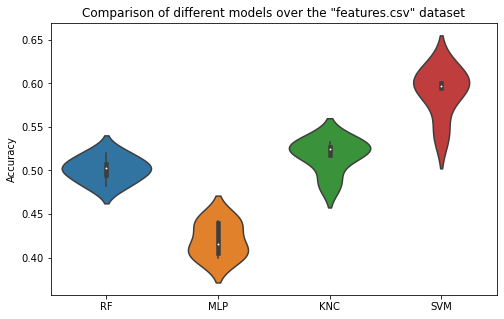

In [15]:
features_accuracies_df = pd.DataFrame()
features_accuracies_df['RF']  =  rf_cc.nested_scores
features_accuracies_df['MLP'] = mlp_cc.nested_scores
features_accuracies_df['KNC'] = knc_cc.nested_scores
features_accuracies_df['SVM'] = svm_cc.nested_scores
print('Scores of the models over the cross validation folds:')
display(features_accuracies_df)

fig, ax = plt.subplots(1, 1, figsize=(8,5))
sns.violinplot(data=features_accuracies_df, ax=ax)
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of different models over the "features.csv" dataset');

So from this first analysis over the dataset _features.csv_ we obtain quite good results: getting an average accuracy over the 50% with just 2000 clips for 50 different classes and classifiers that are not even complicated is a nice starting point for our work. Moreover, what we can say is that SVM work better on the dataset respect to the other models while random forests and KNeighbors classifiers behave, more or less, in the same way; in the end we have the perceptron, that turned out to have the worst performance over the features file, that however is not that far either, from the results of its mates. <br>
For a deeper analysis one could check, for example, directly the confusion matrices of the 4 classifiers, maybe to check if they behave similarly for different classes, or there is one performing better in a particular field respect to the others and so on. Moreover, one could also study the performances over the larger macro-categories, simply re-mapping the labels stored in the last column of the dataframe, to check how much such models are able to distinguish at least among those macro areas. But this notebook is not going through it for now, since it would make this analysis too much long and boring, and maybe it's better to guarantee such deeper analysis only to the classifier that in the end will turn out to be the best.

One could also show that, on average, the scores calculated with the nested cross validation are all slightly bigger than the ones obtained with a non-nested approach: this means, as expected, that we are effectively reducing the overfitting and the information leakage between the train and validation sets. <br>
But, according to the methods that we have applied, are we sure that the statistics found, with such a small amount of data, is credible? Later on we will see that it effectively is, but for the moment we will keep what we obtain as a qualitative result.

We have left some open questions or, better, some statements that have not been proved yet, in the first notebook. Now we will go one-by-one through them with the purpose of providing at least a qualitative answer on the fact that a technique/procedure is better than another, justifying also many of the choices made previously in the analysis.

### Impact of the dimensionality reduction 

Working with large sized vectors of features could be very memory and time demanding, especially when training a complex classifier, maybe with a big number of parameters. For this reason one usually implement, before passing the data to the algorithm, a dimensionality reduction step, in our case a Principal Component Analysis, with the purpose of reducing the dimension of each input vector, while keeping the "information" provided by it as untouched as possible. But how this step influence the performances of our classifiers?

Before showing it let's give a look at the following plot, that allow us to determine the number of principal components to keep without loosing too much of that "information". Basically, during the PCA, you are projecting your data into a smaller dimensional vector space, and each principal component corresponds to an eigenvalue of the covariance matrix of the dataset: reducing the size of the problem means keeping only the first K eigenvalues, i.e. the ones with the higher variance. In the plot it is represented the cumulative explained variance as a function of the number of components kept: the closer to 1 is the value, the more will be the information kept.

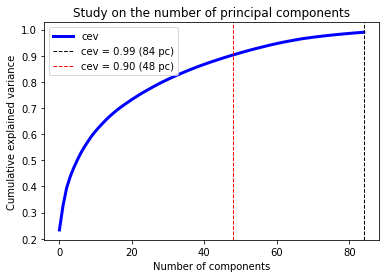

In [34]:
# Let's retrieve the PCA fitted objects from one of our models: since the PCA is computed before the training
# step, the results will be the same for each classifier
PCA_fitted = svm_cc.clf.best_estimator_['pca']

cev = np.cumsum(PCA_fitted.explained_variance_ratio_)
plt.plot(cev, color='blue', lw=3, label='cev')

# Let's plot some typical thresholds
plt.axvline(np.argmax(cev>0.99), ls='--', c='black', lw=1, label='cev = 0.99 ({} pc)'.format(np.argmax(cev>0.99)))
plt.axvline(np.argmax(cev>0.90), ls='--', c='red', lw=1, label='cev = 0.90 ({} pc)'.format(np.argmax(cev>0.90)))

plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Study on the number of principal components')
plt.legend()

See? You can potentially keep the 90% of the information stored in your features with just 48 values! <br>
The accuracies plot in the previous section has been computed keeping all the principal components of the data, so basically applying no PCA. What would happen, instead, reducing the number of eigenvalues to keep?

In [127]:
def test_models_principal_component(features, n_components):
    accuracies = {}
    training_times = {}
    
    start = time.time()
    rf = ClipsClassifier(dataset=features).Setup_Classifier(encoder_method='label', pca_components=n_components, verbose=0)
    rf.Run_Nested_Cross_Validation(model=RandomForestClassifier(), parameters={})
    accuracies['RF'] = [np.mean(rf.nested_scores)]
    training_times['RF'] = [time.time() - start]
    
    start = time.time()
    mlp = ClipsClassifier(dataset=features).Setup_Classifier(pca_components=n_components, verbose=0)
    mlp.Run_Nested_Cross_Validation(model=MLPClassifier(), parameters={})
    accuracies['MLP'] = [np.mean(mlp.nested_scores)]
    training_times['MLP'] = [time.time() - start]
    
    start = time.time()
    knc = ClipsClassifier(dataset=features).Setup_Classifier(pca_components=n_components, verbose=0)
    knc.Run_Nested_Cross_Validation(model=KNeighborsClassifier(), parameters={})
    accuracies['KNC'] = [np.mean(knc.nested_scores)]
    training_times['KNC'] = [time.time() - start]
    
    start = time.time()
    svm = ClipsClassifier(dataset=features).Setup_Classifier(encoder_method='label', pca_components=n_components, verbose=0)
    svm.Run_Nested_Cross_Validation(model=SVC(), parameters={})
    accuracies['SVM'] = [np.mean(svm.nested_scores)]
    training_times['SVM'] = [time.time() - start]
    
    return accuracies, training_times

In [128]:
acc_vs_comp = pd.DataFrame()
time_vs_comp = pd.DataFrame()
component_list = [1, 5, 10, 20, 35, 50, 75, 100, 110]

for n_components in tqdm(component_list):
    
    acc, times = test_models_principal_component(features, n_components)
    acc_vs_comp = pd.concat([acc_vs_comp, pd.DataFrame(acc)])
    time_vs_comp = pd.concat([time_vs_comp, pd.DataFrame(times)])
    
acc_vs_comp['Components'] = component_list
time_vs_comp['Components'] = component_list

  0%|          | 0/9 [00:00<?, ?it/s]

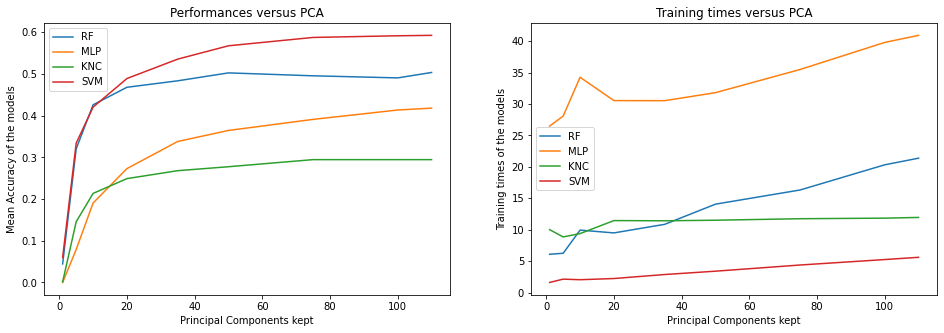

In [129]:
fig, axs = plt.subplots(1, 2, figsize=(16,5))

sns.lineplot(x='Components', y='RF',  data=acc_vs_comp, ax=axs[0], label='RF')
sns.lineplot(x='Components', y='MLP', data=acc_vs_comp, ax=axs[0], label='MLP')
sns.lineplot(x='Components', y='KNC', data=acc_vs_comp, ax=axs[0], label='KNC')
sns.lineplot(x='Components', y='SVM', data=acc_vs_comp, ax=axs[0], label='SVM')
axs[0].set_title('Performances versus PCA')
axs[0].set_xlabel('Principal Components kept')
axs[0].set_ylabel('Mean Accuracy of the models')
axs[0].legend()

sns.lineplot(x='Components', y='RF',  data=time_vs_comp, ax=axs[1], label='RF')
sns.lineplot(x='Components', y='MLP', data=time_vs_comp, ax=axs[1], label='MLP')
sns.lineplot(x='Components', y='KNC', data=time_vs_comp, ax=axs[1], label='KNC')
sns.lineplot(x='Components', y='SVM', data=time_vs_comp, ax=axs[1], label='SVM')
axs[1].set_title('Training times versus PCA')
axs[1].set_xlabel('Principal Components kept')
axs[1].set_ylabel('Training times of the models')
axs[1].legend();

### Importance of the statistical estimators of the features distributions

One of the datasets that we have created previously is called *reduced_features.csv*, and the main difference with respect to the data used in the previous section is that, in order to summarize the various distributions of the *features per frame*, identified and collected in the first notebook, we used only their *mean*, without caring of the *standard deviation*. In this way, the "vectors of features" so created will be of size (55,) rather than (110,), leading to a much smaller dataset; but will this influence the final performances of the classifiers?

In [12]:
red_feat_rf = ClipsClassifier(dataset=reduced_features).Setup_Classifier(encoder_method='label', verbose=0)
red_feat_rf.Run_Nested_Cross_Validation(model=RandomForestClassifier(), parameters=params_RF)

red_feat_mlp = ClipsClassifier(dataset=reduced_features).Setup_Classifier(verbose=0)
red_feat_mlp.Run_Nested_Cross_Validation(model=MLPClassifier(), parameters=params_MLP)

red_feat_knc = ClipsClassifier(dataset=reduced_features).Setup_Classifier(verbose=0)
red_feat_knc.Run_Nested_Cross_Validation(model=KNeighborsClassifier(), parameters=params_KNC)

red_feat_svm = ClipsClassifier(dataset=reduced_features).Setup_Classifier(encoder_method='label', verbose=0)
red_feat_svm.Run_Nested_Cross_Validation(model=SVC(), parameters=params_SVM)

/home/mattia/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Scores of the models over the cross validation folds:


,red_RF,red_MLP,red_KNC,red_SVM
0,0.3425,0.2025,0.3600,0.3925
1,0.3350,0.2225,0.3450,0.4100
2,0.3750,0.2000,0.3550,0.3925
3,0.3025,0.2225,0.3275,0.3850
4,0.3675,0.2275,0.3600,0.4150


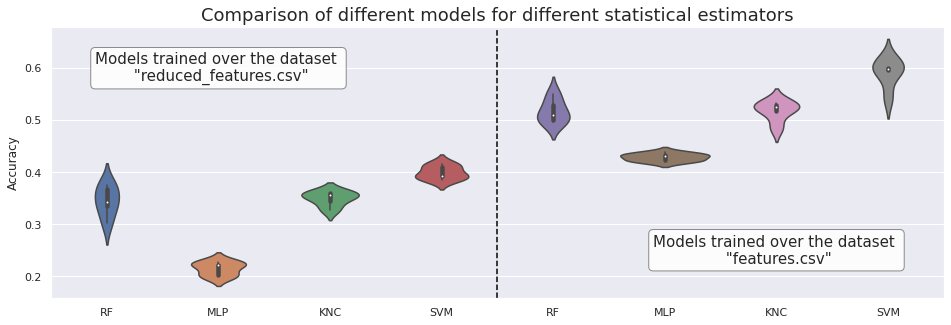

In [64]:
red_features_accuracies_df = pd.DataFrame()
red_features_accuracies_df['red_RF'] = red_feat_rf.nested_scores
red_features_accuracies_df['red_MLP'] = red_feat_mlp.nested_scores
red_features_accuracies_df['red_KNC'] = red_feat_knc.nested_scores
red_features_accuracies_df['red_SVM'] = red_feat_svm.nested_scores

print('Scores of the models over the cross validation folds:')
display(red_features_accuracies_df)

fig, ax = plt.subplots(1, 1, figsize=(16,5))
sns.violinplot(data=pd.concat([red_features_accuracies_df, features_accuracies_df]), ax=ax)
ax.axvline(3.5, ls='--', c='black')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of different models for different statistical estimators', fontsize=18)
ax.set_xticklabels(['RF', 'MLP', 'KNC', 'SVM', 'RF', 'MLP', 'KNC', 'SVM'])

ax.text(1, 0.6, 'Models trained over the dataset \n "reduced_features.csv"', ha="center", va="center", size=15, 
        bbox=dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9))
ax.text(6, 0.25, 'Models trained over the dataset \n "features.csv"', ha="center", va="center", size=15, 
        bbox=dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9));

The improvement is obvious: using both the mean and the standard deviation as statistics estimators of the features distributions almost doubles the accuracy obtained with **all** the models used. The explanation has already by shown in the first notebook, giving a direct look at the interested plots; most of the times, in fact, such distributions are quite asymmetric and non-gaussian and taking just the average is probably just an excess of reductionism.

### Importance of the silence removal step

Another version of the feature dataset is _features_nosilenceremoval.csv_

### Overfitting

In [ ]:
classifiers_performances

In [ ]:
for i in classifiers_performances.values():print(i)

In [ ]:
def flatten_dict(d):
    def items():
        for key, value in d.items():
            if isinstance(value, dict):
                for subkey, subvalue in flatten_dict(value).items():
                    yield key + "." + subkey, subvalue
            else:
                yield key, value

    return dict(items())
flatten(classifiers_performances)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.set_ylim(0,1)

for method in classifiers_performances.values():
    sns.boxplot(y=method['features'])


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
for label in classifiers_performances_df['index']:
    sns.boxplot(x=label, y=classifiers_performances_df[classifiers_performances_df['index']==label])


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
sns.boxplot(x=1, y=classifiers_performances['random_forest']['more_features'], ax=ax)
sns.boxplot(x=2, y=classifiers_performances['multi_layer_perceptron']['more_features'], ax=ax)
sns.boxplot(y=classifiers_performances['k_neighbors_classifier']['more_features'], ax=ax)
sns.boxplot(y=classifiers_performances['support_vector_machine']['more_features'], ax=ax)

### Neural Network

In [ ]:
def Compute_Prediction(clip, model):
    """Given a trained model over the clips dataset, this function is designed to plot a visual su"""

In [ ]:
svm_cc.best_model

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
def create_NN(optimizer='adamax', dropout_prob=0.1, lr=0.01):
    
    model = tf.keras.models.Sequential()
    #model.add(tf.keras.layers.InputLayer(input_shape=())
    #model.add(tf.keras.layers.Dense(512))
    #model.add(tf.keras.layers.Dropout(0.1))
    #model.add(tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001))
    #model.add(tf.keras.layers.PReLU())
    model.add(tf.keras.layers.Dense(256))
    model.add(tf.keras.layers.Dropout(dropout_prob))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001))
    model.add(tf.keras.layers.PReLU())
    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.Dropout(dropout_prob))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001))
    model.add(tf.keras.layers.PReLU())
    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.Dropout(dropout_prob))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001))
    model.add(tf.keras.layers.PReLU())
    model.add(tf.keras.layers.Dense(50))
    model.add(tf.keras.layers.Softmax())

    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == 'adamax':
        optimizer = tf.keras.optimizers.Adamax(learning_rate=lr)
        
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [ ]:
NN = KerasClassifier(build_fn=create_NN, verbose=0)

params_NN = {'epochs':[100], 'batch_size':[64, 128], 'optimizer':['adam', 'adamax'], 'lr':[0.01, 0.001], 
             'dropout_prob':[0.1, 0.5]}

nn_cc = ClipsClassifier(augmented_features)
nn_cc.Setup_Classifier(pca_percentage=1)
nn_cc.Run_Training_Process()

In [ ]:
nn_cc.nested_scores

In [ ]:
nn_cc = ClipsClassifier(augmented_features)
nn_cc._Setup_Data()

In [ ]:
model = create_NN()
history = model.fit(nn_cc.X, nn_cc.Y, epochs=100, batch_size=128, verbose=0, 
                        callbacks=[TqdmCallback(verbose=1)], validation_split=0.2)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [ ]:
model.evaluate(cc.X_test, cc.Y_test)